Can we predict which authors have written what 

In [15]:
import os
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import string
from nltk.stem import PorterStemmer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from gensim.models import Word2Vec
from sklearn.svm import SVC

nltk.download('punkt') # for tokenizing

# Helper function to read data from a labeled directory
def read_data_from_directory(directory_path):
    authors = os.listdir(directory_path)
    if '.DS_Store' in authors:
        authors.remove('.DS_Store')
    texts = []
    labels = []
    for author in authors:
        author_path = os.path.join(directory_path, author)
        for file_name in os.listdir(author_path):
            if file_name != '.DS_Store':
                file_path = os.path.join(author_path, file_name)
                with open(file_path, 'r', encoding='utf-8') as f:
                    texts.append(f.read())
                    labels.append(author)
    return texts, labels

# Reading the training and test data
train_texts, train_labels = read_data_from_directory('./datafile/ReutersC50/C50train')
test_texts, test_labels = read_data_from_directory('./datafile/ReutersC50/C50test')


[nltk_data] Downloading package punkt to /Users/carson/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
word_tokenize(train_texts[0])

['Drugstore',
 'giant',
 'Revco',
 'D.S',
 '.',
 'Inc.',
 'said',
 'Monday',
 'it',
 'agreed',
 'to',
 'buy',
 'regional',
 'chain',
 'Big',
 'B',
 'Inc.',
 'in',
 'a',
 'sweetened',
 'takeover',
 'valued',
 'at',
 '$',
 '380',
 'million',
 '.',
 'The',
 'transaction',
 'calls',
 'for',
 'Twinsburg',
 ',',
 'Ohio-based',
 'Revco',
 'to',
 'buy',
 'all',
 'outstanding',
 'shares',
 'of',
 'Big',
 'B',
 'common',
 'stock',
 'for',
 '$',
 '17.25',
 'per',
 'share',
 ',',
 'up',
 'from',
 'Revco',
 "'s",
 'unsolicited',
 'offer',
 'of',
 '$',
 '15',
 'per',
 'share',
 ',',
 'which',
 'Big',
 'B',
 'rejected',
 'last',
 'month',
 '.',
 '``',
 'We',
 'are',
 'very',
 'excited',
 'about',
 'the',
 'combination',
 'of',
 'Revco',
 'and',
 'Big',
 'B.',
 'I',
 'am',
 'pleased',
 'we',
 'were',
 'able',
 'to',
 'bring',
 'this',
 'process',
 'to',
 'a',
 'fast',
 'and',
 'successful',
 'conclusion',
 ',',
 "''",
 'said',
 'Dwayne',
 'Hoven',
 ',',
 'president',
 'and',
 'chief',
 'executive',
 '

In [17]:
# Helper function to tokenize, remove punctuation, and stem
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Tokenize
    tokens = word_tokenize(text.lower())
    
    # Remove punctuation
    tokens = [token for token in tokens if token not in string.punctuation and token not in stop_words]
    
    # Stemming
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    
    return stemmed_tokens

def preprocess_text2(text):
    tokens = word_tokenize(text.lower())
    
    # Remove punctuation
    tokens = [token for token in tokens if token not in string.punctuation and token not in stop_words]
    return " ".join(tokens)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/carson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Basic Statistics
print(f"Total number of training documents: {len(train_texts)}")
print(f"Total number of test documents: {len(test_texts)}")

train_doc_lengths = [len(preprocess_text(text)) for text in train_texts]
test_doc_lengths = [len(preprocess_text(text)) for text in test_texts]

print(f"\nAverage document length in training set: {np.mean(train_doc_lengths)} words")
print(f"Minimum document length in training set: {np.min(train_doc_lengths)} words")
print(f"Maximum document length in training set: {np.max(train_doc_lengths)} words")
print(f"\nAverage document length in test set: {np.mean(test_doc_lengths)} words")
print(f"Minimum document length in test set: {np.min(test_doc_lengths)} words")
print(f"Maximum document length in test set: {np.max(test_doc_lengths)} words")


Total number of training documents: 2500
Total number of test documents: 2500

Average document length in training set: 328.4308 words
Minimum document length in training set: 33 words
Maximum document length in training set: 957 words

Average document length in test set: 333.2564 words
Minimum document length in test set: 42 words
Maximum document length in test set: 934 words



Most common words across the training set:
said: 19856
's: 14872
'': 13882
``: 13712
year: 6146
compani: 5651
would: 5237
percent: 5211
million: 4942
market: 4629


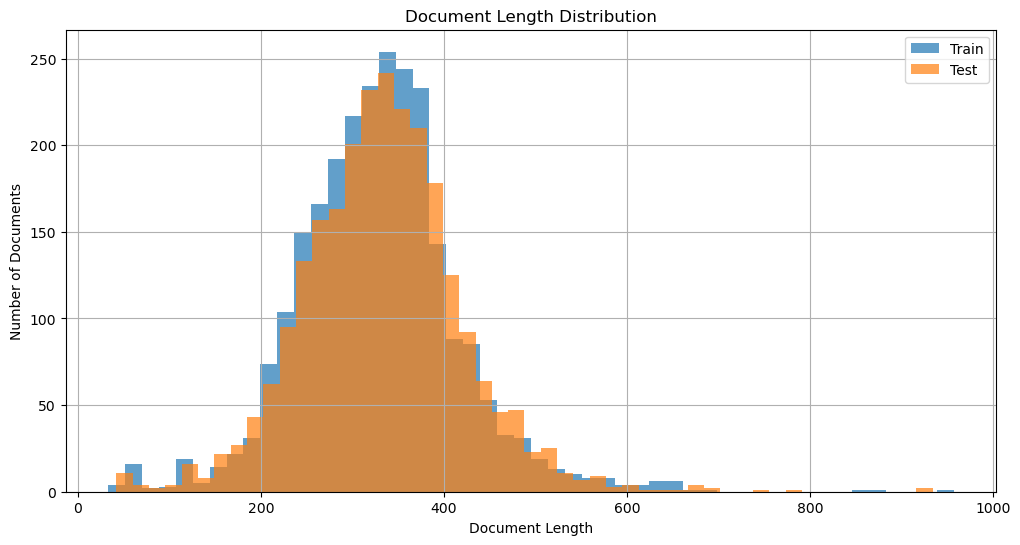

In [5]:
# Term Frequencies
all_tokens = [token for text in train_texts for token in preprocess_text(text)]
common_tokens = Counter(all_tokens).most_common(10)
print("\nMost common words across the training set:")
for token, freq in common_tokens:
    print(f"{token}: {freq}")

# Document Length Distribution
plt.figure(figsize=(12, 6))
plt.hist(train_doc_lengths, bins=50, alpha=0.7, label='Train')
plt.hist(test_doc_lengths, bins=50, alpha=0.7, label='Test')
plt.title('Document Length Distribution')
plt.xlabel('Document Length')
plt.ylabel('Number of Documents')
plt.legend()
plt.grid(True)
plt.show()


In [10]:
# The CountVectorizer will now use my custom tokenizer/preprocesser
vectorizer = CountVectorizer(tokenizer=preprocess_text, stop_words='english', max_features=2500)

train_dtm = vectorizer.fit_transform(train_texts)
test_dtm = vectorizer.transform(test_texts)

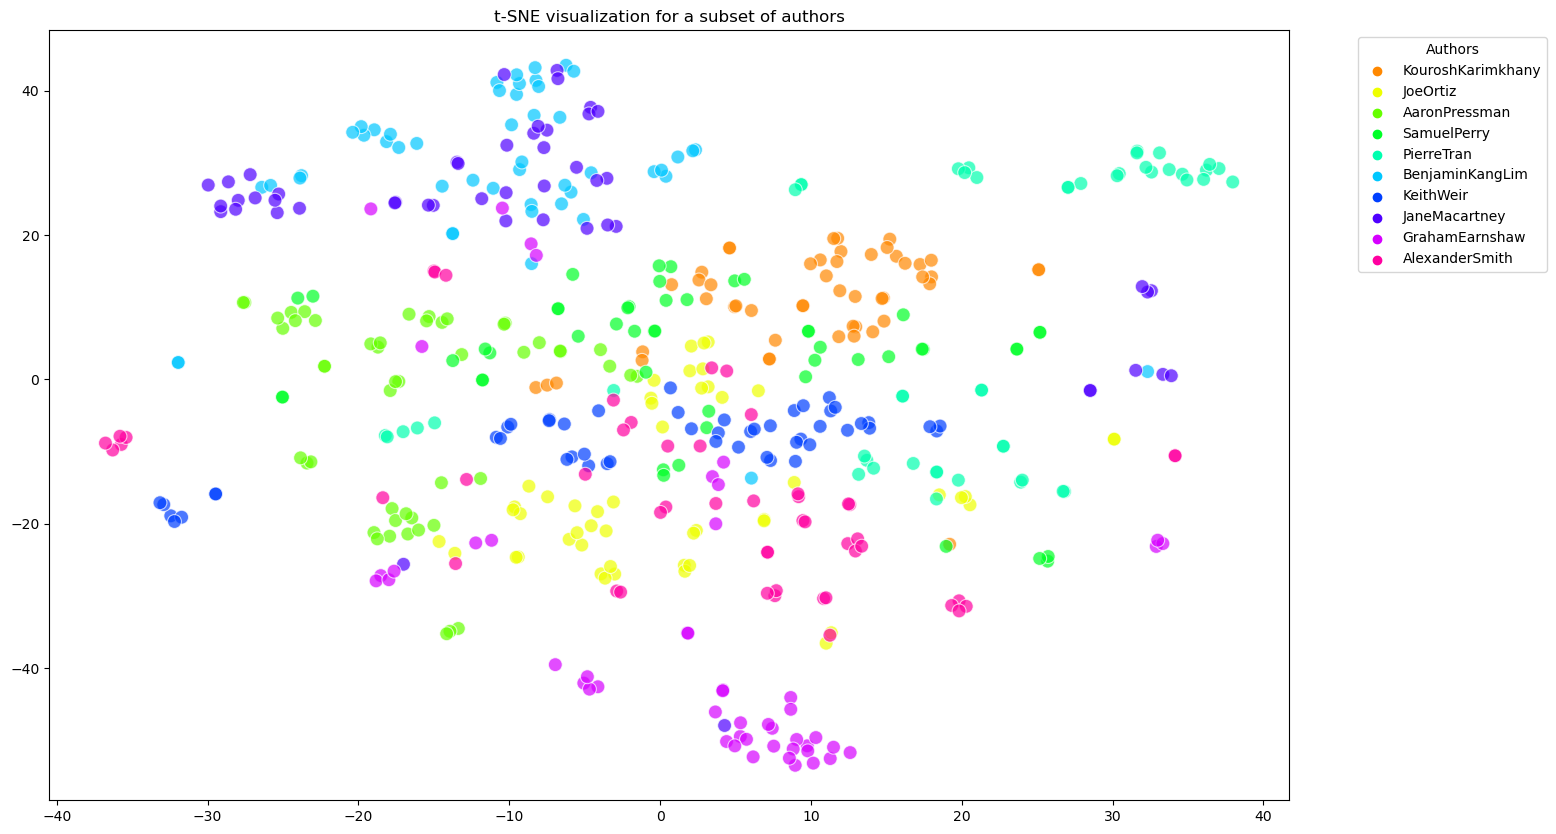

In [11]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import random

# 1. Choose a subset of 10 authors
unique_authors = list(set(train_labels))
selected_authors = random.sample(unique_authors, 10)

# 2. Filter the training data
filtered_indices = [i for i, label in enumerate(train_labels) if label in selected_authors]
filtered_texts = [train_texts[i] for i in filtered_indices]
filtered_labels = [train_labels[i] for i in filtered_indices]
filtered_dtm = train_dtm[filtered_indices]

# 3. PCA and t-SNE
pca = PCA(n_components=100)
reduced_data_pca = pca.fit_transform(filtered_dtm.toarray())  # Convert sparse matrix to dense matrix
tsne = TSNE(n_components=2, perplexity=20)
tsne_results = tsne.fit_transform(reduced_data_pca)

# 4. Plotting
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x=tsne_results[:, 0], y=tsne_results[:, 1],
    hue=filtered_labels,
    palette=sns.color_palette("hsv", len(selected_authors)),
    alpha=0.7,
    s=100
)
plt.title('t-SNE visualization for a subset of authors')
plt.legend(title='Authors', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [13]:
# Create and train the Naive Bayes classifier
classifier = MultinomialNB()
classifier.fit(train_dtm, train_labels)

# Make predictions on the test data
predictions = classifier.predict(test_dtm)

# Calculate accuracy
accuracy = accuracy_score(test_labels, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.6472


In [23]:
# Train SVM classifier
classifier = SVC()
classifier.fit(train_dtm, train_labels)

# Make predictions on the test data
predictions = classifier.predict(test_dtm)

# Calculate accuracy
accuracy = accuracy_score(test_labels, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.622


In [21]:
train_texts_preprocessed = [preprocess_text2(text) for text in train_texts]
test_texts_preprocessed = [preprocess_text2(text) for text in test_texts]


In [22]:
# Preprocess the training and test data

# Train Word2Vec model
model = Word2Vec(sentences=train_texts_preprocessed, vector_size=100, window=5, min_count=1, workers=4)

# Function to average word vectors to get document vectors

def average_word_vectors(words, model, num_features):
    feature_vector = np.zeros((num_features,), dtype="float32")
    num_words = 0
    for word in words:
        if word in model.wv:
            num_words += 1
            feature_vector = np.add(feature_vector, model.wv[word])
    if num_words > 0:
        feature_vector = np.divide(feature_vector, num_words)
    return feature_vector


# Create document vectors using Word2Vec
train_data = [average_word_vectors(text, model, 100) for text in train_texts_preprocessed]
test_data = [average_word_vectors(text, model, 100) for text in test_texts_preprocessed]

# Train SVM classifier
classifier = SVC()
classifier.fit(train_data, train_labels)

# Make predictions on the test data
predictions = classifier.predict(test_data)

# Calculate accuracy
accuracy = accuracy_score(test_labels, predictions)
print("Accuracy:", accuracy)


Accuracy: 0.1436


In [ ]:
# Create and train the Naive Bayes classifier
classifier = MultinomialNB()
classifier.fit(train_data, train_labels)

# Make predictions on the test data
predictions = classifier.predict(test_dtm)

# Calculate accuracy
accuracy = accuracy_score(test_labels, predictions)
print("Accuracy:", accuracy)